# Exact, automatic P-T Jacobians for H$_2$O transmission spectrum
## For a single layer Earth atmosphere
### Using HITRAN, `jax`, and NVIDIA GPUs

Here we replicate the behavior of `hapi` with GPU- and autodiff- aware `jax` framework.

In [1]:
%%capture
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

In [2]:
! du -hs ../../hapi/data/

272M	../../hapi/data/


In [3]:
#hapi.describeTable('H2O')

### Convert from $\text{cm}^{-1}$ to Angstroms.

In [4]:
wls = (np.arange(15000, 25000, 1.0) * u.Angstrom)[::-1]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

You can calculate the partition function with HAPI.

In [5]:
hapi.partitionSum(1,1, [296])

[174.58122640000002]

In [6]:
h2o_vol_mix_ratio_air = 1.0e-3

In [7]:
%%time
nu, coeff_air = hapi.absorptionCoefficient_Lorentz(SourceTables='H2O', Diluent={'air':1.0-h2o_vol_mix_ratio_air, 'H2O':h2o_vol_mix_ratio_air}, WavenumberGrid=nus.tolist(), HITRAN_units=True)#range(4000,10000,1))

{'air': 0.999, 'H2O': 0.001}
CPU times: user 6.25 s, sys: 11.7 ms, total: 6.26 s
Wall time: 6.26 s


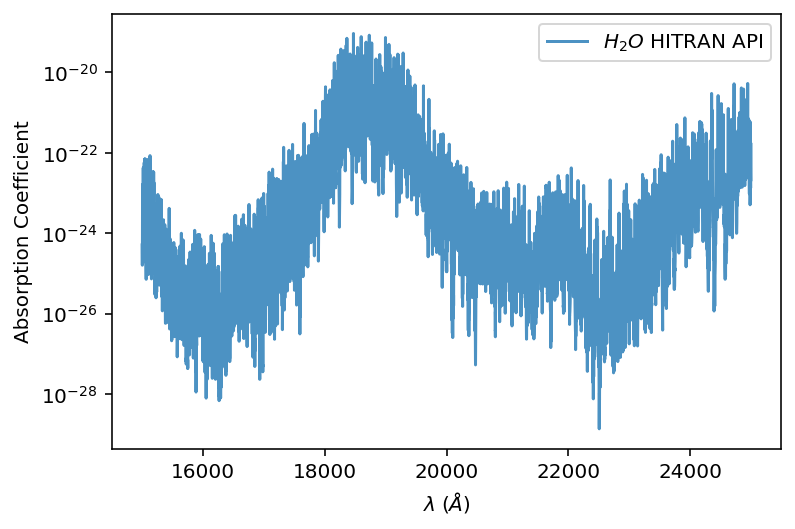

In [8]:
plt.plot(wls, coeff_air, label='$H_2O$ HITRAN API', alpha=0.8)
plt.legend()
plt.ylabel('Absorption Coefficient')
plt.yscale('log')
plt.xlabel('$\lambda \;(\AA)$');

The net absorption coefficient depends on the pressure of the environment.  We'll have to include those effects later.

### Direct computation of the absorption coefficient with GPUs

We will include the linewings across the entire passband!

In [9]:
from jax.config import config
config.update("jax_enable_x64", True)

In [10]:
import jax.numpy as np
from jax import vmap, jit, grad, random

Compute Lorentz Profiles:  
$$ f_{L}(\nu; \nu_{ij}, T, p) = \frac{1}{\pi}\frac{\gamma(p, T)}{\gamma(p,T)^2, + [\nu-(\nu_{ij}+\delta(p_{ref})p)]^2}$$

We'll make an array that is $N_{lines} \times N_{wl}$ in size

In [11]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

Let's try to map this function across all entries in the water line list.

In [12]:
n_air = hapi.getColumn('H2O', 'n_air')
gamma_air = hapi.getColumn('H2O', 'gamma_air')
gamma_self = hapi.getColumn('H2O', 'gamma_self')

In [13]:
%%time
gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(1.0, 296.0,0.001, n_air, gamma_air, gamma_self)

CPU times: user 88 ms, sys: 160 ms, total: 248 ms
Wall time: 330 ms


Yay!  We have our gammas to input into the Lorentz profile function

In [14]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [15]:
nu_lines = hapi.getColumn('H2O', 'nu')
delta_air = hapi.getColumn('H2O', 'delta_air')
S_ij = hapi.getColumn('H2O', 'sw')

In [16]:
nus, wls = np.array(nus), np.array(wls)
nus.shape, gammas.shape

((10000,), (44902,))

In [17]:
%%time
line_profile = jit(vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0)))(nus, np.array(1.0),
                                     nu_lines, gammas, delta_air, S_ij)
line_profile.shape

CPU times: user 18.6 ms, sys: 12.1 ms, total: 30.7 ms
Wall time: 81.1 ms


(44902, 10000)

Nice!  The *net* absorption coefficient is the sum on all lines:

In [18]:
%%time
net_abs_coeff = line_profile.sum(axis=0)

CPU times: user 16.9 ms, sys: 8.06 ms, total: 25 ms
Wall time: 80.5 ms


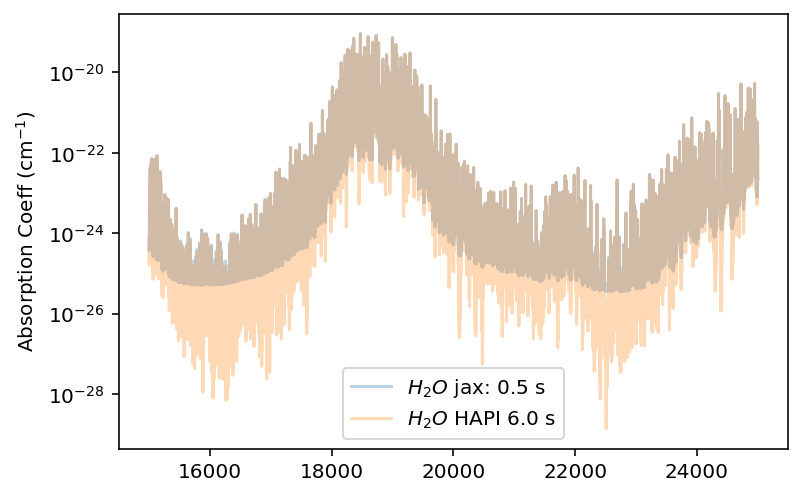

In [19]:
plt.plot(wls, net_abs_coeff, alpha=0.3, label='$H_2O$ jax: 0.5 s')


plt.plot(wls, coeff_air, label='$H_2O$ HAPI 6.0 s', alpha=0.3)
plt.yscale('log')
plt.ylabel('Absorption Coeff (cm$^{-1}$)')
plt.legend(loc='best');

Yay!  We did it!  We're **more accurate** than HAPI since we include the line wing contributions across the entire spectrum.  We're not yet doing the partition function though, so let's hold off on saying we're faster, until we can do a head-to-head comparison.

In [20]:
from jax import jacfwd

In [21]:
abs_of_p = jit(lambda p: vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0))

In [22]:
jacfwd(abs_of_p)(1.0)

DeviceArray([ 1.82877066e-24,  4.21682214e-24, -2.94372716e-23, ...,
             -9.21421292e-28,  2.97300549e-27,  1.32570575e-26],            dtype=float64)

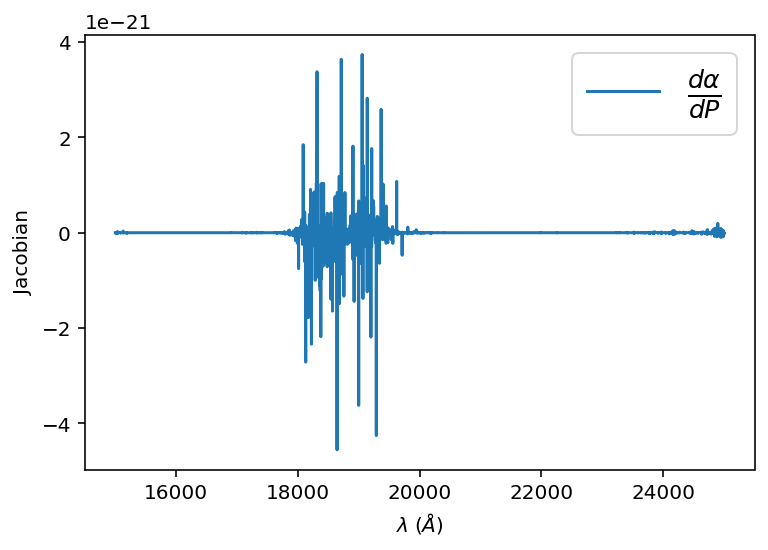

In [23]:
plt.plot(wls, jit(jacfwd(abs_of_p))(1.0), label=r'$\frac{d \alpha}{dP}$')
plt.legend(fontsize=18)
plt.ylabel('Jacobian')
plt.xlabel('$\lambda \;(\AA)$');

Awesome!  Let's put it all together for Temperature.

### Temperature Jacobian

In [24]:
@jit
def abs_coeff_of_T(T):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(1.0, T,0.001, n_air, gamma_air, gamma_self)
    
    return vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, 1.0,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)

In [25]:
%%time
abs_temp_jacobian = jacfwd(abs_coeff_of_T)(296.0)

CPU times: user 86.4 ms, sys: 16 ms, total: 102 ms
Wall time: 169 ms


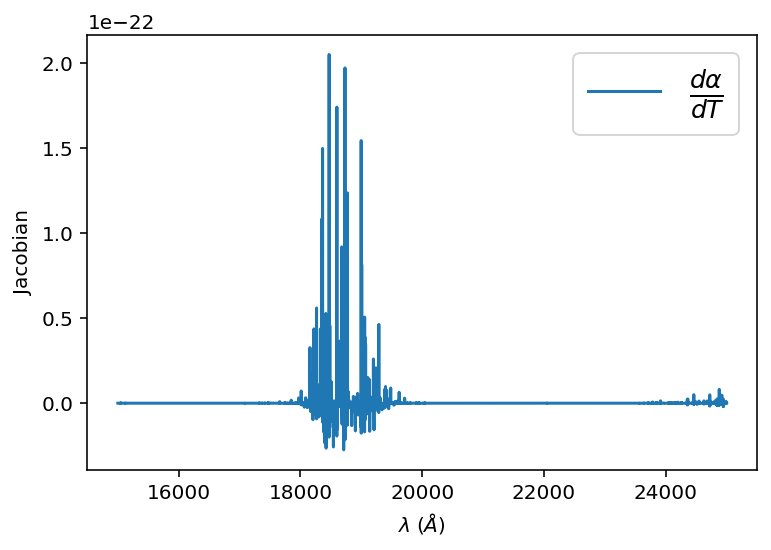

In [26]:
plt.plot(wls, abs_temp_jacobian, label=r'$\frac{d \alpha}{dT}$')
plt.legend(fontsize=18)
plt.ylabel('Jacobian')
plt.xlabel('$\lambda \;(\AA)$');

### Let's compute the transmission spectrum!

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [27]:
path_length = (3.0*u.km).to(u.cm).value

In [28]:
water_number_density =  (0.001*6.022e23/(22.4*u.liter)).to(u.cm**-3) # molecules cm^-3

In [29]:
tau_of_nu = net_abs_coeff * water_number_density * path_length

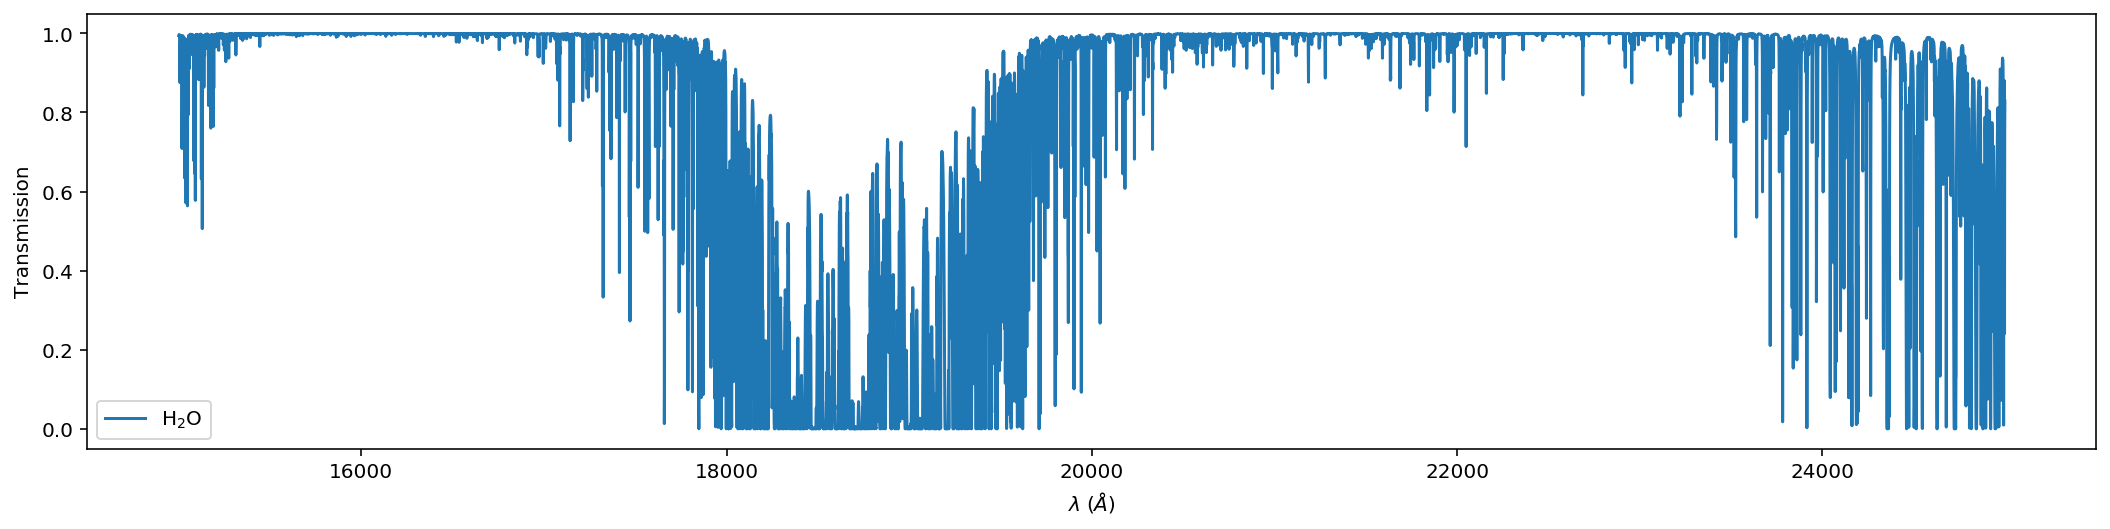

In [30]:
plt.figure(figsize=(18,4))
plt.plot(wls, np.exp(-tau_of_nu), label='H$_2$O')
plt.legend()
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$');

Hooray!  That's the telluric absorption due to Earth's atmospheric water, under extreme assumptions that the atmosphere is composed of a single 3 km thick isothermal layer at STP.  But those assumptions can be relaxed later to yield more accurate estimates.

In [31]:
@jit
def transmission_of_T_p(T, p):
    '''Return the absorption coefficient as a function of T'''
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,0.001, n_air, gamma_air, gamma_self)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    
    tau = abs_coeff * water_number_density.value * path_length
    return np.exp(-tau)

In [32]:
%%time
_ = jacfwd(transmission_of_T_p, argnums=0)(296.0, 1.0)

CPU times: user 90.3 ms, sys: 16.2 ms, total: 106 ms
Wall time: 181 ms


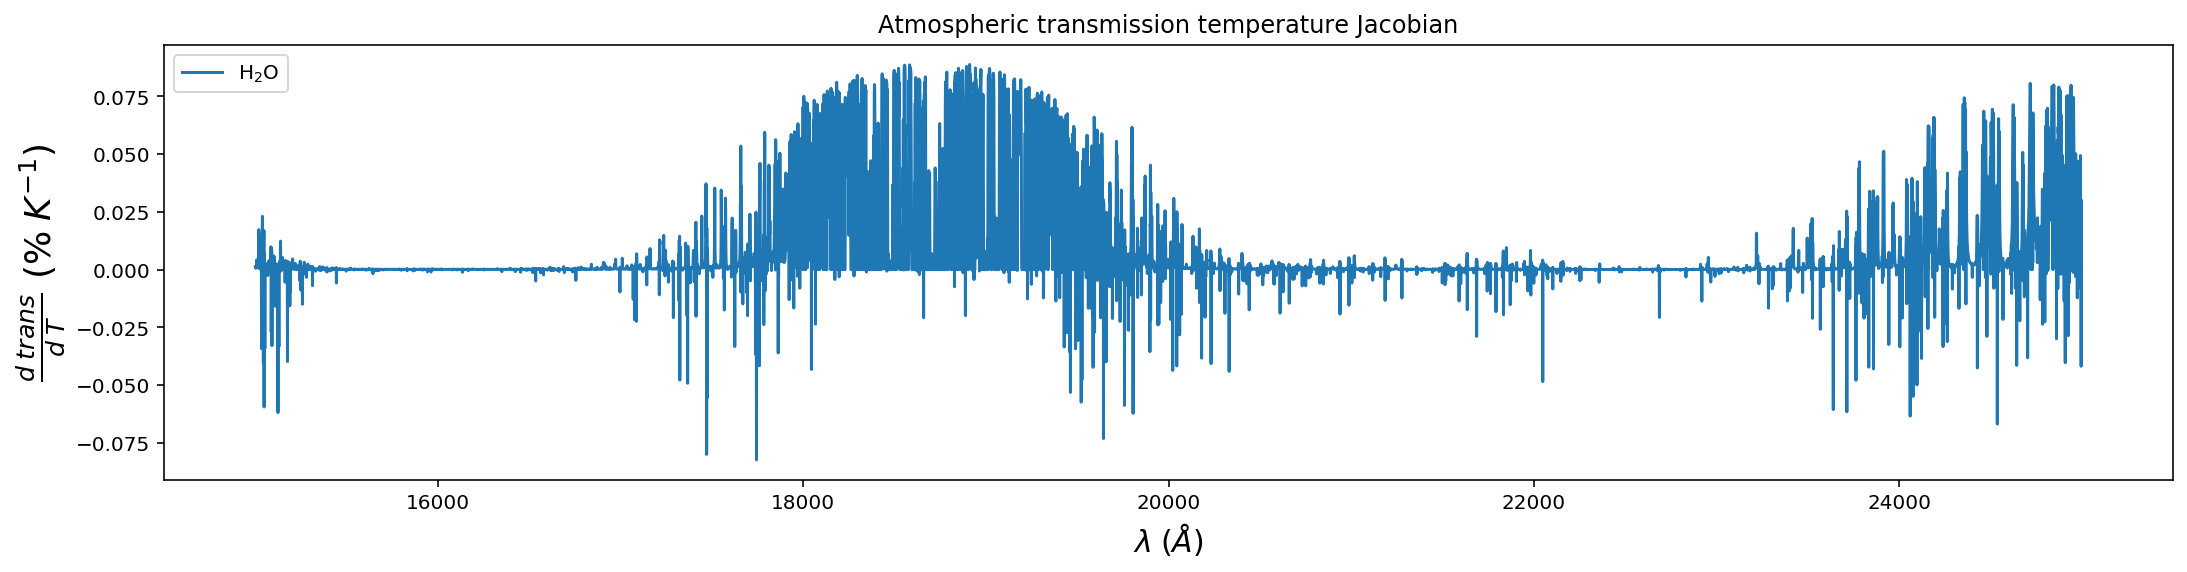

In [33]:
plt.figure(figsize=(18,4))
plt.plot(wls, jacfwd(transmission_of_T_p, argnums=0)(296.0, 1.0)*100.0, label='H$_2$O ')
plt.legend()
plt.ylabel(r'$\frac{d\;trans}{d\;T}$ ($\% \;K^{-1}$)', fontdict={'fontsize':18})
plt.xlabel('$\lambda \;(\AA)$',fontdict={'fontsize':15})
plt.title('Atmospheric transmission temperature Jacobian');

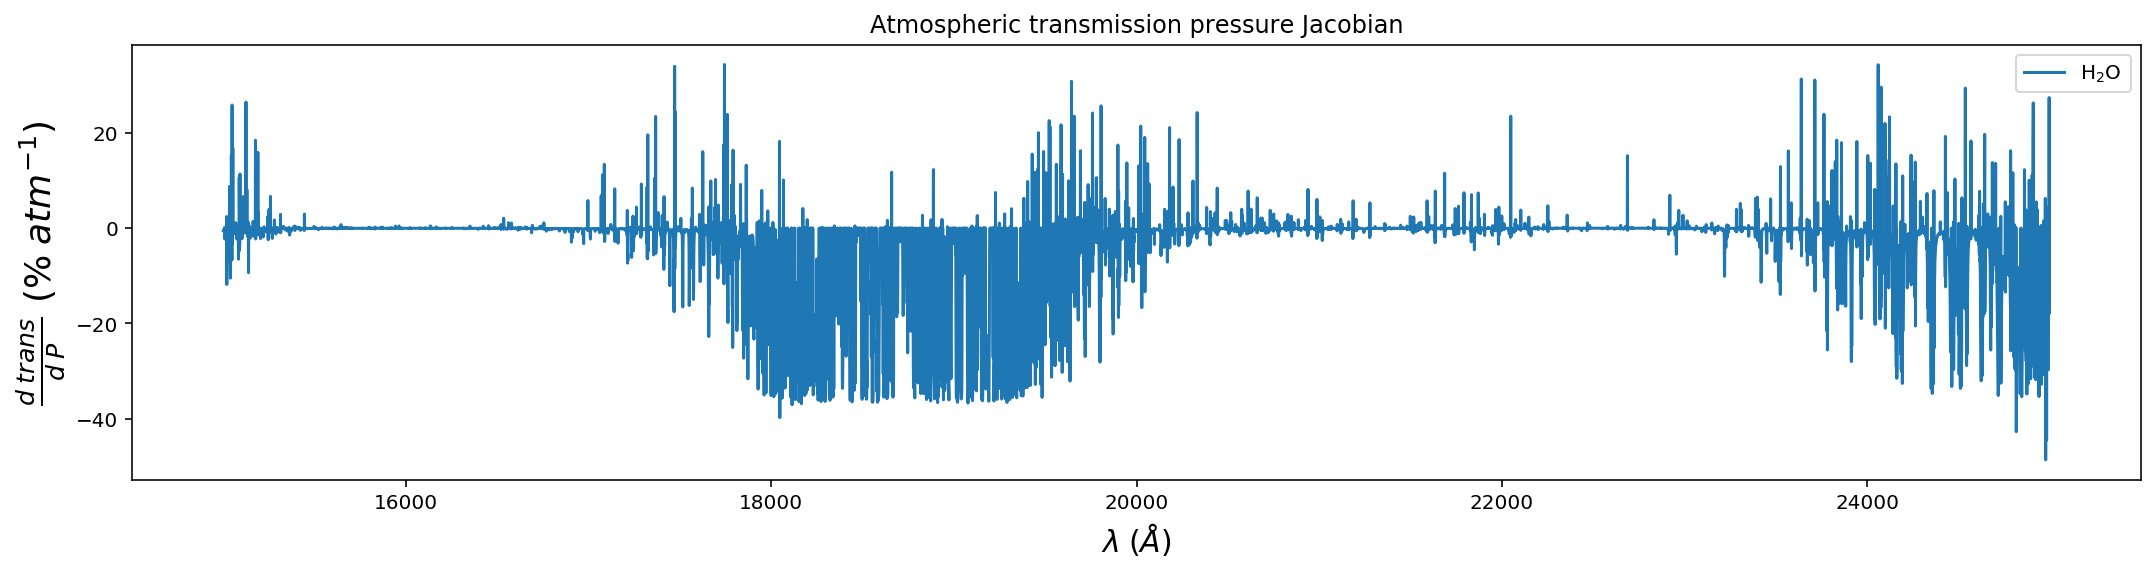

In [34]:
plt.figure(figsize=(18,4))
plt.plot(wls, jacfwd(transmission_of_T_p, argnums=1)(296.0, 1.0)*100.0, label='H$_2$O ')
plt.legend()
plt.ylabel(r'$\frac{d\;trans}{d\;P}$ ($\% \;atm^{-1}$)', fontdict={'fontsize':18})
plt.xlabel('$\lambda \;(\AA)$',fontdict={'fontsize':15})
plt.title('Atmospheric transmission pressure Jacobian');

Awesome!  We made good progress.  What are the next steps?

#### 1. Include the temperature dependence of the cross section (and partition function)
So far I have only included the temperature dependence of the Lorentzian broadening, but not the temperature dependence of the cross-section amplitude $S_{ij}$.  I had been leaving this out because it requires computing the partition function, for which I am still understanding the HITRAN TIPS implementation.

#### 2. Add more vertical layers, with variable P-T profile.
We want to simulate a realistic atmosphere that has multiple vertical layers, with a varying P-T profile.

#### 3. Make sure I'm using `jit` and `vmap` correctly.
I've noticed that I can run out of RAM on my GPU if I don't use `jit`, and the `vmap` dimension handling/broadcasting remains a bit confusing for me.

#### 4. Attempt to fit with fake data.
Can we use Jacobian-aware minimization techniques to fit the spectral lines at high resolution?